**Učitavanje podataka**

In [1]:
import dataset.stanford_background_dataset as sbd
import torch.utils.data as data
import torch
import matplotlib.pyplot as plt
import resnet
import numpy as np
import dataset.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import math

transform = transforms.ToTensor()
print('Loading data...')
dataset = sbd.StanfordBackgroundDataset('./data', 'horizons.txt', transform=transform)
print('Dataset loaded.')
dataloader = data.DataLoader(dataset, batch_size=4, shuffle=True)
print('Dataloader loaded.')

net = resnet.resnet50()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.train()
criterion = nn.CrossEntropyLoss(ignore_index=10)
optimizer = optim.Adam(net.parameters())

Loading data...
Dataset loaded.
Dataloader loaded.


**Učenje**

In [2]:
for epoch in range(50):
    if epoch == 35:
        optimizer = optim.Adam(net.parameters(), lr=1e-4)
    for i, sample in enumerate(dataloader, 0):

        inputs, labels = sample['image'], sample['region']
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print('[%d, %5d] loss: %.9f' %
                (epoch + 1, i + 1, loss.item()))

print('Finished Training')
torch.save(net.state_dict(), './net.pt')


[1,     1] loss: 57.083736420
[1,   501] loss: 1.483415604
[1,  1001] loss: 1.377218843
[2,     1] loss: 1.375936627
[2,   501] loss: 1.628472090
[2,  1001] loss: 1.351338506
[3,     1] loss: 1.043329477
[3,   501] loss: 1.019075036
[3,  1001] loss: 0.896606684
[4,     1] loss: 0.937821686
[4,   501] loss: 0.967631876
[4,  1001] loss: 1.563068748
[5,     1] loss: 0.945033371
[5,   501] loss: 1.742913842
[5,  1001] loss: 2.147412777
[6,     1] loss: 1.288415790
[6,   501] loss: 1.138998866
[6,  1001] loss: 1.547103524
[7,     1] loss: 0.737184346
[7,   501] loss: 1.324154139
[7,  1001] loss: 0.958624601
[8,     1] loss: 0.776074529
[8,   501] loss: 0.735366166
[8,  1001] loss: 1.176543474
[9,     1] loss: 0.934284210
[9,   501] loss: 0.993023098
[9,  1001] loss: 0.460389793
[10,     1] loss: 0.600340903
[10,   501] loss: 0.941147625
[10,  1001] loss: 0.700481653
[11,     1] loss: 1.034060836
[11,   501] loss: 0.883750737
[11,  1001] loss: 1.213645577
[12,     1] loss: 0.754220963
[12,  

In [0]:
def cut_img(img, shape):
    h_cut = 320 - shape[0]
    w_cut = 320 - shape[1]
    h_cut_top = math.ceil(h_cut / 2)
    h_cut_btm = h_cut - h_cut_top
    w_cut_left = math.ceil(w_cut / 2)
    w_cut_right = w_cut - w_cut_left
    img = img[:, h_cut_top:, w_cut_left:]
    img = img[:, :img.shape[1] - h_cut_btm, :img.shape[2] - w_cut_right]
    return img


def cut_label(label, shape):
    h_cut = 320 - shape[0]
    w_cut = 320 - shape[1]
    h_cut_top = math.ceil(h_cut / 2)
    h_cut_btm = h_cut - h_cut_top
    w_cut_left = math.ceil(w_cut / 2)
    w_cut_right = w_cut - w_cut_left
    label = label[h_cut_top:, w_cut_left:]
    label = label[:label.shape[0] - h_cut_btm, :label.shape[1] - w_cut_right]
    return label
  

def show_imgs(sample_batched, cMap):
    images_batch, labels_batch, shape = sample_batched['image'], sample_batched['region'], sample_batched['shape']
    batch_size = len(images_batch)
    for i in range(batch_size):
        plt.subplot(2, 4, i+1).axis('off')
        img = images_batch[i]
        img = img.cpu().numpy()
        img_shape = shape[0][i], shape[1][i]
        img = cut_img(img, img_shape)
        img = img.transpose((1, 2, 0))
        plt.imshow(img)
    for j in range(batch_size, batch_size * 2):
        plt.subplot(2, 4, j + 1).axis('off')
        img = labels_batch[j - batch_size]
        img_shape = shape[0][j - batch_size], shape[1][j - batch_size]
        img = img.cpu().numpy()
        img = cut_label(img, img_shape)
        plt.imshow(img, cmap=cMap, vmin=0, vmax=9)
    plt.show()


def show_res(res, shape, cMap):
    for i in range(len(res)):
        img = res[i].cpu().detach().numpy()
        img_shape = shape[0][i], shape[1][i]
        img = cut_label(img, img_shape)
        plt.subplot(1, 4, i+1)
        plt.imshow(img, cmap=cMap, vmin=0, vmax=9)
    plt.show()


**Točnost**

In [14]:
net = resnet.resnet50()
net.load_state_dict(torch.load('./net.pt'))
net.eval()
net.to(device)
transform = transforms.Compose([transforms.ToTensor()])
dataset = sbd.StanfordBackgroundDataset('./data', 'horizons.txt', mode='val', transform=transform)
dataloader = data.DataLoader(dataset, batch_size=4, shuffle=False)
corr_eval_pix = 0;
n_pix = 0
for i, val_sample in enumerate(dataloader):
    shape = val_sample['shape']
    output = net(val_sample['image'])
    result = torch.argmax(output, dim=1)
    result = result.cpu().numpy()
    t_labels = val_sample['region'].cpu().numpy()
    for j in range(len(result)):
        lbl_shape = shape[0][j], shape[1][j]
        label = cut_label(result[j], lbl_shape)
        t_label = cut_label(t_labels[j], lbl_shape)
        n_pix += label.size
        corr_eval_pix += np.sum(label == t_label)

print('corr={}, n={}'.format(corr_eval_pix, n_pix))
print('tocnost = {}'.format(corr_eval_pix / n_pix))

corr=6778322, n=8616320
tocnost = 0.7866841064398722


**Prikaz rezultata**

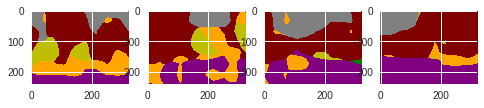

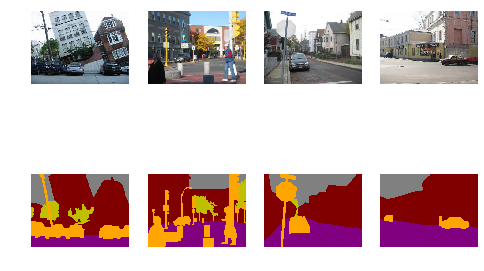

--------------


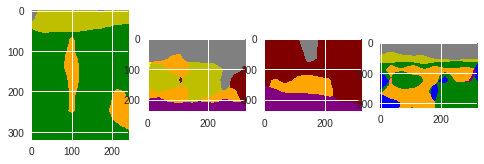

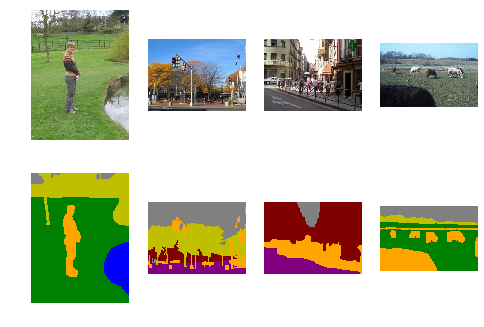

--------------


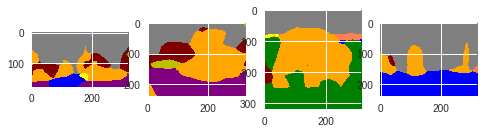

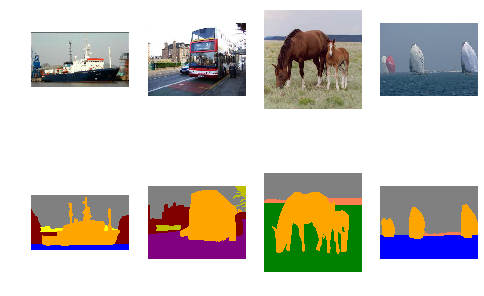

--------------


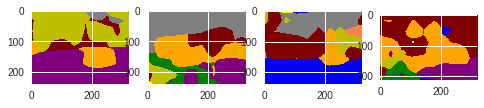

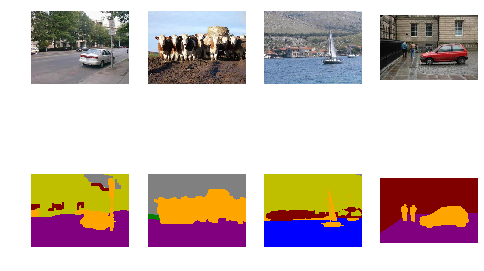

--------------


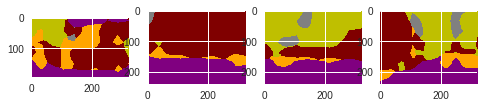

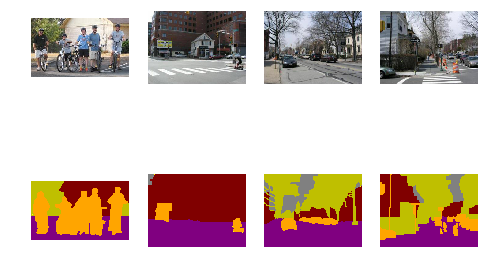

--------------


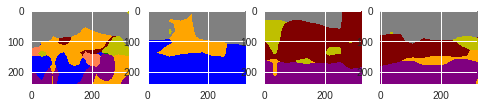

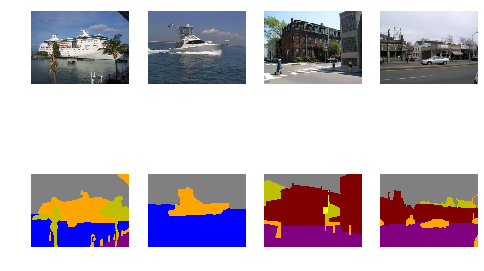

--------------


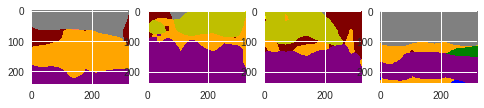

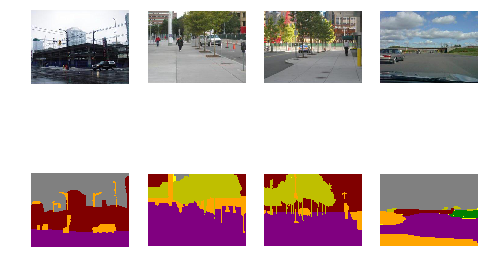

--------------


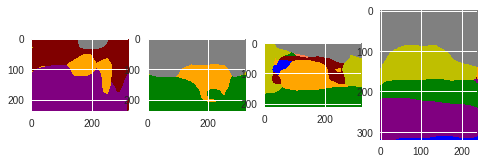

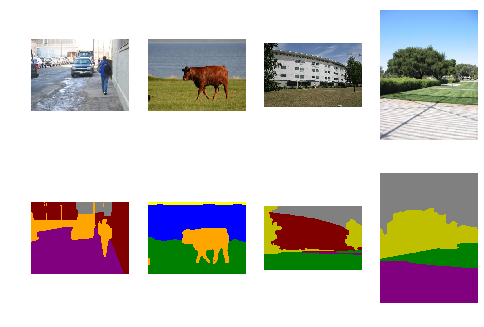

--------------


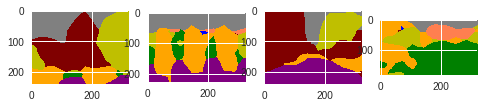

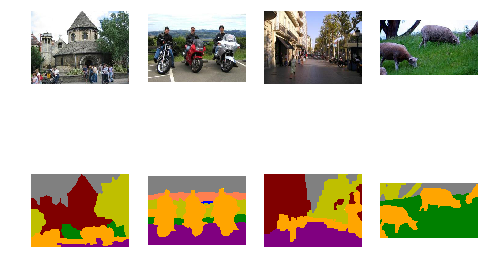

--------------


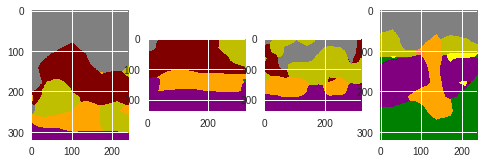

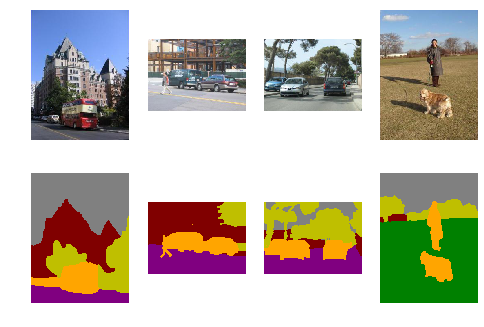

--------------


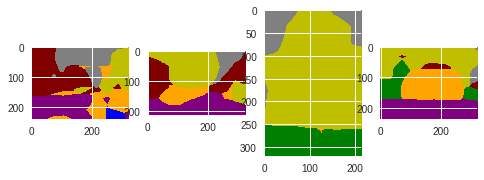

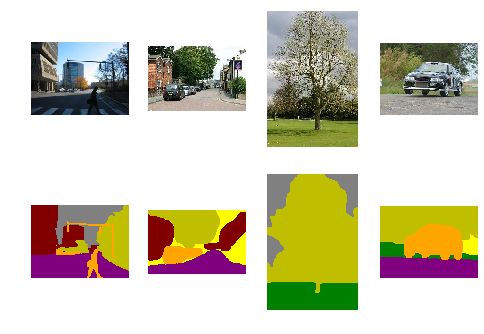

--------------


In [15]:
from matplotlib.colors import ListedColormap
dataset = sbd.StanfordBackgroundDataset(
            '/content/drive/My Drive/zavrsni/data', 'horizons.txt',
            transform=transform, mode='test')
dataloader = data.DataLoader(dataset, batch_size=4, shuffle=False)
cMap = ListedColormap(['yellow', 'gray', 'y', 'purple', 'green', 'blue', 'maroon', 'coral', 'orange'])

for i, test_sample in enumerate(dataloader):
    output = net(test_sample['image'])
    res = torch.argmax(output, dim=1)
    show_res(res, test_sample['shape'], cMap)
    show_imgs(test_sample, cMap)
    print('--------------')
    if i == 10:
        break


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
